In [54]:
! pip install geopandas
! pip install pandas
! pip install pygeos
! pip install boto
! pip install s3fs
! pip install shapely
! pip install gcsfs
!pip install contextily
!pip install matplotlib-scalebar
!pip install sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import time
from itertools import groupby
import geopandas as gpd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2950 sha256=d24a9689762d2b8f297ea1fa48b269e38f3b690c15c670d5bf5c78706f8b3443
  Stored in directory: /home/jovyan/.cache/pip/wheels/de/6a/05/7cad3fe50c04cfcba9f13bf25766f6fa85764e4f76f5c4fd98
Successfully built sklearn


In [2]:
def addGeometryIdToDataFrame(df, gdf, xcol, ycol, idColumn="geometry"): 
    gdf.crs = {'init': 'epsg:2263'}
    gdf_data = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[xcol], df[ycol]))
    gdf_data.crs = {'init': 'epsg:32118'}
    joined = gpd.sjoin(gdf_data.to_crs('epsg:26910'), gdf.to_crs('epsg:26910'))
    gdf_data = gdf_data.merge(joined['ZIPCODE'], left_index=True, right_index=True, how="left")
    gdf_data.rename(columns={'ZIPCODE': idColumn}, inplace=True)
    df = pd.DataFrame(gdf_data.drop(columns='geometry'))
    # df.drop(columns=[xcol, ycol], inplace=True)
    
    return df.loc[~df.index.duplicated(keep='first'), :]

In [3]:
def plot_map(scenario_name, dpi, result_dict_tra, result_dict_work, result_dict_work_ess, BGs, vmaxes, vmines):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    dfs = [result_dict_tra, result_dict_work, result_dict_work_ess]
    titles = ["Share_Transit_trips", "Share_Work_trips", "Share_Work_Ess_trips"]
    titles_ = ["Transit usage rate among zip code residents \n %s"%(scenario_name), "Work activities rate among zip code residents \n %s"%(scenario_name), "Households with essential worker rate \n %s"%(scenario_name)]

    cmap = "viridis"

    gdf = BGs
    gdf = gdf.to_crs('EPSG:3857')

    for i, (df, title, title_, vmax, vmin)  in enumerate(zip(dfs, titles, titles_, vmaxes, vmines)):


        # Join the two dataframes on a common attribute
        merged = gdf.merge(df, on="ZIPCODE")

        # Plot the merged data using the values from the pandas DataFrame
        merged.plot(column=title, cmap=cmap, ax=axes[i], alpha=0.9, norm=plt.Normalize(vmin=vmin, vmax=vmax))

        # Add a legend
        # vmin, vmax = merged[title].min(), merged[title].max()
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        ctx.add_basemap(axes[i], source=ctx.providers.Stamen.TonerLite, alpha=0.8, attribution_size=4)
        axes[i].text(0.05, 0.9, "N\n↑", ha="center", va="center", transform=axes[i].transAxes, fontsize=14)

        scalebar = ScaleBar(3, "m", length_fraction=0.2, height_fraction=0.02, frameon=False, location='lower right')
        axes[i].add_artist(scalebar)

        # Create a colorbar axis
        cax = fig.add_axes([0.12 + i*0.275, 0.07, 0.235, 0.02])

        # Add a colorbar to the plot using the color map and normalization instance
        cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
        cb.ax.tick_params(labelsize=8)
        tick_fmt = ticker.FormatStrFormatter('%.2f')
        cb.ax.xaxis.set_major_formatter(tick_fmt)
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(title_)

    plt.savefig("outputs/%s.png"%(scenario_name), dpi=dpi)
    
    return True

In [4]:

def process(Persons, Households, pop, plans):
    person_to_hs = dict(zip(Persons.index, Persons.householdId))
    hs_to_x = dict(zip(Households.householdId, Households.locationX))
    hs_to_y = dict(zip(Households.householdId, Households.locationY)) 
    person_to_x = {key: hs_to_x[person_to_hs[key]] for key in person_to_hs}
    person_to_y = {key: hs_to_y[person_to_hs[key]] for key in person_to_hs}


    
    plans = plans[plans['planSelected']==True]
    plans = plans.sort_values(by=['personId','planElementIndex'], ascending=True)
    plans['activityLocationX'] = plans['personId'].map(person_to_x)
    plans['activityLocationY'] = plans['personId'].map(person_to_y)


    plans_act = plans[(plans['activityType'].notnull())&(plans['activityType']!='Home')]
    plans_trip = plans[plans['legMode'].notnull()]
    plans_work = plans[plans['activityType']=='Work']
    plans_transit = plans[(plans['legMode']=='walk_transit')|(plans['legMode']=='drive_transit')|(plans['legMode']=='ride_hail_transit')|(plans['legMode']=='bike_transit')]



    
    plans_work = addGeometryIdToDataFrame(plans_work, BGs, 'activityLocationX', 'activityLocationY', 'ZIP')
    plans_transit = addGeometryIdToDataFrame(plans_transit, BGs, 'activityLocationX', 'activityLocationY', 'ZIP')
    plans_act = addGeometryIdToDataFrame(plans_act, BGs, 'activityLocationX', 'activityLocationY', 'ZIP')
    plans_trip = addGeometryIdToDataFrame(plans_trip, BGs, 'activityLocationX', 'activityLocationY', 'ZIP')

    pop_ess = pop[pop['industry']=='educational / health']
    hs_tot = pop.drop_duplicates(subset=['household_id'])
    hs_work_ess = pop_ess.drop_duplicates(subset=['household_id'])
    hs_tot['activityLocationX'] = hs_tot['household_id'].map(hs_to_x)

    hs_tot['activityLocationY'] = hs_tot['household_id'].map(hs_to_y)
    hs_work_ess['activityLocationX'] = hs_work_ess['household_id'].map(hs_to_x)
    hs_work_ess['activityLocationY'] = hs_work_ess['household_id'].map(hs_to_y)

    hs_tot = addGeometryIdToDataFrame(hs_tot, BGs, 'activityLocationX', 'activityLocationY', 'ZIP')
    hs_work_ess = addGeometryIdToDataFrame(hs_work_ess, BGs, 'activityLocationX', 'activityLocationY', 'ZIP')

    plans_work_dict = plans_work.ZIP.value_counts().to_dict()
    plans_transit_dict = plans_transit.ZIP.value_counts().to_dict()
    plans_act = plans_act.ZIP.value_counts().to_dict()
    plans_trip = plans_trip.ZIP.value_counts().to_dict()
    hs_tot_dict = hs_tot.ZIP.value_counts().to_dict()
    hs_work_dict = hs_work_ess.ZIP.value_counts().to_dict()

    result_dict_work_ess = {key: hs_work_dict[key]/hs_tot_dict[key] for key in hs_work_dict if key in hs_tot_dict if hs_tot_dict[key]> 50}
    result_dict_work = {key: plans_work_dict[key]/plans_act[key] for key in plans_work_dict if key in plans_act if plans_act[key]> 50}
    result_dict_tra = {key: plans_transit_dict[key]/plans_trip[key] for key in plans_transit_dict if key in plans_trip if plans_trip[key]> 50}

    df1 = pd.DataFrame.from_dict(result_dict_work, orient='index', columns=['Share_Work_trips'])
    df1.index.name = 'ZIPCODE'

    df2 = pd.DataFrame.from_dict(result_dict_tra, orient='index', columns=['Share_Transit_trips'])
    df2.index.name = 'ZIPCODE'

    df3 = pd.DataFrame.from_dict(result_dict_work_ess, orient='index', columns=['Share_Work_Ess_trips'])
    df3.index.name = 'ZIPCODE'
    
    return df1, df2, df3


In [5]:
#Read
BGs = gpd.read_file('inputs/ZIP_CODE_040114.shp')
pop = pd.read_csv('outputs/persons_baseline.csv.gz', index_col=0)

Persons_base = pd.read_csv('outputs/Merged_Pop_Baseline_4.csv.gz', index_col=0)
Households_base = pd.read_csv('outputs/Merged_Hs_Baseline.csv.gz', index_col=0)

plans_1 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-baseline-0-of-10__2023-01-03_19-59-12_nwn/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_2 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-baseline-1-of-10__2023-01-03_19-59-13_jgp/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_3 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-baseline-2-of-10__2023-01-03_19-59-06_brm/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_4 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-baseline-3-of-10__2023-01-03_19-59-07_kqr/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_5 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-baseline-4-of-10__2023-01-03_19-59-09_fbb/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_6 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-baseline-5-of-10__2023-01-03_19-59-11_tjh/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_7 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-baseline-6-of-10__2023-01-03_19-59-12_zwm/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_8 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-baseline-7-of-10__2023-01-03_19-59-19_bcr/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_9 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-baseline-8-of-10__2023-01-03_19-59-14_olx/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_0 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-baseline-9-of-10__2023-01-03_19-59-07_xcc/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])

plans_base = pd.concat([plans_0,plans_1,plans_2,plans_3,plans_4,
                            plans_5,plans_6,plans_7,plans_8,plans_9])

Persons_May2022 = pd.read_csv('outputs/Merged_Pop_May2022_4.csv.gz', index_col=0)
Households_May2022 = pd.read_csv('outputs/Merged_Hs_May2022.csv.gz', index_col=0)

plans_1 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-june2022-0-of-10__2023-01-10_16-53-18_iir/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_2 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-june2022-1-of-10__2023-01-10_16-53-23_mrs/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_3 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-june2022-2-of-10__2023-01-10_16-53-36_log/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_4 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-june2022-3-of-10__2023-01-10_16-53-36_lvd/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_5 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-june2022-4-of-10__2023-01-10_16-53-44_afe/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_6 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-june2022-5-of-10__2023-01-10_16-53-58_gry/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_7 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-june2022-6-of-10__2023-01-10_16-53-59_qdi/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_8 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-june2022-7-of-10__2023-01-10_16-54-13_fwj/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_9 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-june2022-8-of-10__2023-01-10_16-54-18_okl/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_0 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-june2022-9-of-10__2023-01-10_16-54-38_jvb/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])

plans_May2022 = pd.concat([plans_0,plans_1,plans_2,plans_3,plans_4,
                            plans_5,plans_6,plans_7,plans_8,plans_9])

Persons_May2020 = pd.read_csv('outputs/Merged_Pop_May2020_4.csv.gz', index_col=0)
Households_May2020 = pd.read_csv('outputs/Merged_Hs_May2020.csv.gz', index_col=0)

plans_1 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-may2020-0-of-10__2023-01-12_18-51-34_sju/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_2 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-may2020-1-of-10__2023-01-12_18-51-33_nyd/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_3 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-may2020-2-of-10__2023-01-12_18-51-29_yow/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_4 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-may2020-3-of-10__2023-01-12_18-51-36_inx/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_5 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-may2020-4-of-10__2023-01-12_18-51-31_iwm/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_6 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-may2020-5-of-10__2023-01-12_18-51-34_jui/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_7 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-may2020-6-of-10__2023-01-12_18-51-34_gqr/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_8 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-may2020-7-of-10__2023-01-12_18-51-28_juu/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_9 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-may2020-8-of-10__2023-01-12_18-51-36_ehv/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])
plans_0 =     pd.read_csv('s3://beam-outputs/output/newyork/new-york-may2020-9-of-10__2023-01-12_18-51-54_bas/ITERS/it.5/5.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode'])

plans_May2020 = pd.concat([plans_0,plans_1,plans_2,plans_3,plans_4,
                            plans_5,plans_6,plans_7,plans_8,plans_9])

In [6]:
df1_base, df2_base, df3_base = process(Persons_base, Households_base, pop, plans_base)
df1_May2020, df2_May2020, df3_May2020 = process(Persons_May2020, Households_May2020, pop, plans_May2020)
df1_May2022, df2_May2022, df3_May2022 = process(Persons_May2022, Households_May2022, pop, plans_May2022)


/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of 

True

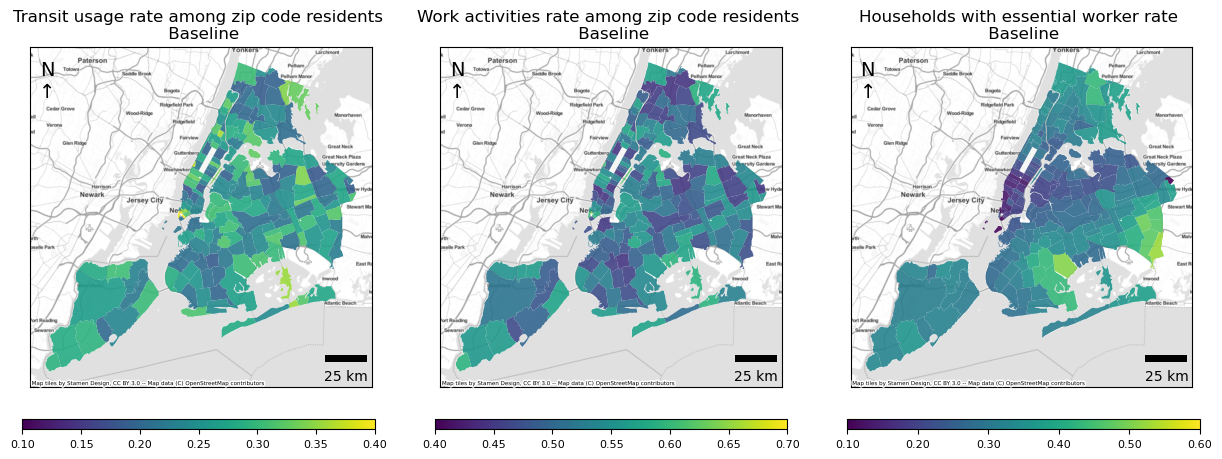

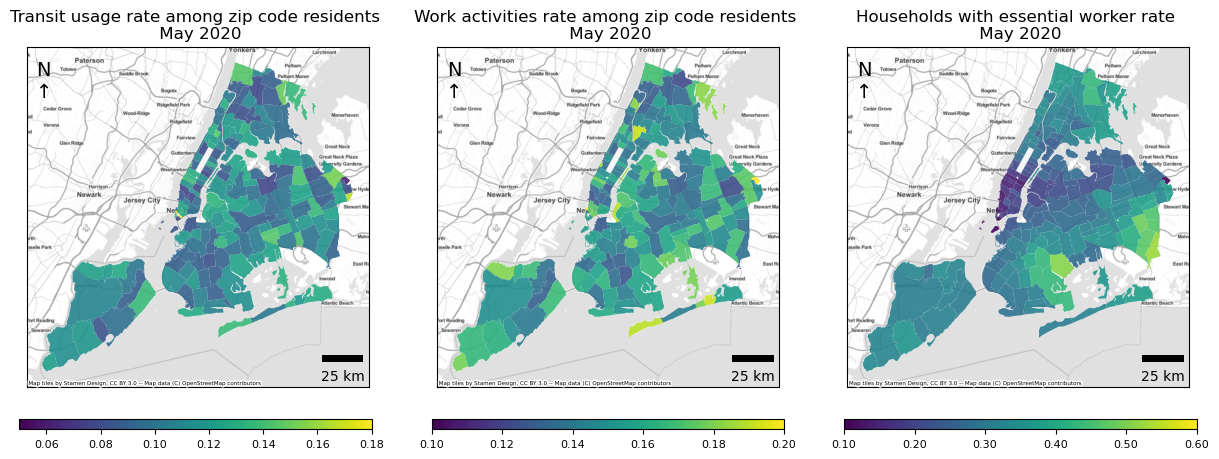

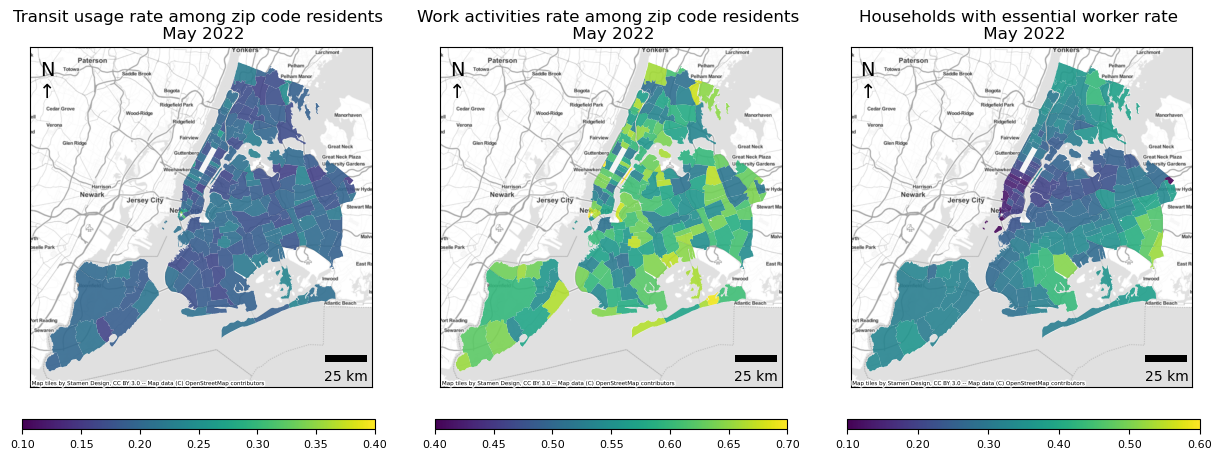

In [62]:
plot_map('Baseline', 500, df2_base, df1_base, df3_base, BGs, vmaxes = [0.4,0.7,0.6], vmines = [0.1,0.4,0.1])
plot_map('May 2020', 500, df2_May2020, df1_May2020, df3_May2020, BGs, vmaxes = [0.18,0.2,0.6], vmines = [0.05,0.1,0.1])
plot_map('May 2022', 500, df2_May2022, df1_May2022, df3_May2022, BGs, vmaxes = [0.4,0.7,0.6], vmines = [0.1,0.4,0.1])

 df2_base, df1_base, df3_base, BGs, vmaxes = [0.4,0.7,0.6], vmines = [0.1,0.4,0.1])
plot_map('May 2020', 100, df2_May2020, df1_May2020, df3_May2020, B

In [ ]:
df2_base-df2_May2020
df1_base-df1_May2020
df2_base

In [11]:
diff1 = {k: df1_base[k] - df1_May2020[k] for k in df1_base.keys() & df1_May2020.keys()}
diff2 = {k: df2_base[k] - df2_May2020[k] for k in df2_base.keys() & df2_May2020.keys()}


/tmp/ipykernel_186/1541169799.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  diff1 = {k: df1_base[k] - df1_May2020[k] for k in df1_base.keys() & df1_May2020.keys()}
/tmp/ipykernel_186/1541169799.py:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  diff2 = {k: df2_base[k] - df2_May2020[k] for k in df2_base.keys() & df2_May2020.keys()}


In [26]:
df1 = pd.DataFrame(diff1).sort_index()

In [27]:
df2 = pd.DataFrame(diff2).sort_index()

In [28]:
df3 = df3_base.sort_index()

In [29]:
df1 = merged_df = pd.merge(df1, df2, left_index=True, right_index=True)
df1 = merged_df = pd.merge(df1, df3, left_index=True, right_index=True)


In [31]:
df1

,Share_Work_trips,Share_Transit_trips,Share_Work_Ess_trips
ZIPCODE,,,
10001,0.388763,0.190428,0.143657
10002,0.336390,0.137023,0.197349
10003,0.316407,0.115635,0.185091
10004,0.318042,0.127708,0.106641
10005,0.445541,0.277266,0.175263
...,...,...,...
11691,0.375214,0.147048,0.375875
11692,0.397343,0.201082,0.358395
11693,0.413787,0.222028,0.355877


y = -0.02x + 0.37
R2 =  0.0033316245218368845


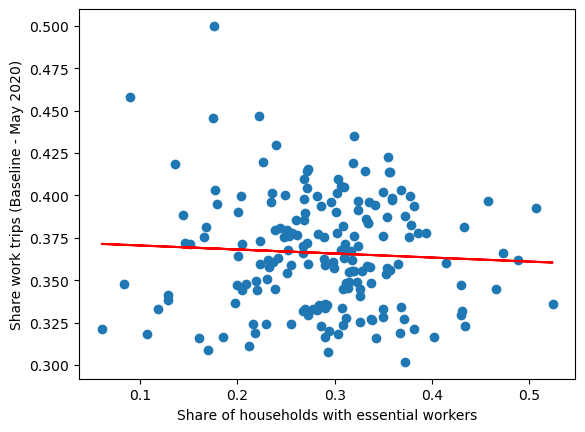

In [60]:

x = list(df1['Share_Work_Ess_trips'])
y = list(df1['Share_Work_trips'])
plt.scatter(y=y, x=x)
m, b = np.polyfit(x, y, 1)
regline = np.poly1d((m, b))
plt.plot(x, regline(x), color='red')
plt.ylabel('Share work trips (Baseline - May 2020)')
plt.xlabel('Share of households with essential workers')
print(f'y = {m:.2f}x + {b:.2f}')
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
y_pred = model.predict(np.array(x).reshape(-1, 1))
r2 = r2_score(y, y_pred)
print('R2 = ',r2)

y = -0.08x + 0.17
R2 =  0.029479687904776064


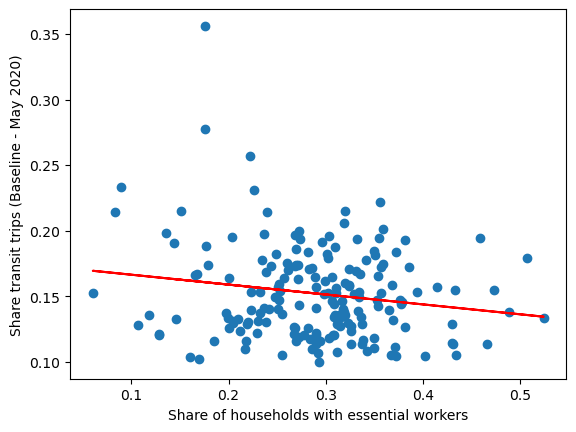

In [61]:
x = list(df1['Share_Work_Ess_trips'])
y = list(df1['Share_Transit_trips'])
plt.scatter(y=y, x=x)
m, b = np.polyfit(x, y, 1)
regline = np.poly1d((m, b))
plt.plot(x, regline(x), color='red')
plt.ylabel('Share transit trips (Baseline - May 2020)')
plt.xlabel('Share of households with essential workers')
print(f'y = {m:.2f}x + {b:.2f}')
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
y_pred = model.predict(np.array(x).reshape(-1, 1))
r2 = r2_score(y, y_pred)
print('R2 = ',r2)